***Imports***

In [120]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from itertools import product
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

# Disable all warnings
warnings.filterwarnings('ignore')

# **Prepping Data for Modeling**

***Importing Data***

In [121]:
df_final = pd.read_csv('../data/processed/df_final_processed_no_bins.csv')
df_final_ohe = pd.read_csv('../data/processed/df_final_processed_OHE.csv')

**Note:** During the part 3 exercise it was noted that the OHE method used in Part 2 was giving errors. In order to bypass these issues, label encoding was used instead.

In [122]:
df_final['city_encoded'] = df_final['city'].astype('category').cat.codes
df_final['type_encoded'] = df_final['type'].astype('category').cat.codes

df_final_part3 = df_final.drop(columns=['city', 'type'])

df_final_part3.to_csv('../data/processed/df_final_part3.csv', index=False)

# **Hyperparameter Tuning**

In [123]:
def custom_cross_validation(training_data, n_splits=5):
    '''creates n_splits sets of training and validation folds

    Args:
      training_data: the dataframe of features and target to be divided into folds
      n_splits: the number of sets of folds to be created

    Returns:
      A tuple of lists, where the first index is a list of the training folds, 
      and the second the corresponding validation fold
    '''

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    training_folds = []
    validation_folds = []

    for train_index, val_index in kf.split(training_data):

        train_fold = training_data.iloc[train_index].copy()
        val_fold = training_data.iloc[val_index].copy()


        # Compute city means on the training folds

        city_means = train_fold.groupby('city_encoded')['price'].mean().rename('city_mean_price')


        # Join these values to both training and validation folds

        train_fold = train_fold.merge(city_means, on='city_encoded', how='left')
        val_fold = val_fold.merge(city_means, on='city_encoded', how='left')


        # Fill NaN values that might appear due to missing cities in validation fold

        train_fold['city_mean_price'] = train_fold['city_mean_price'].fillna(
            train_fold['price'].mean())
        val_fold['city_mean_price'] = val_fold['city_mean_price'].fillna(
            train_fold['price'].mean())

        training_folds.append(train_fold)
        validation_folds.append(val_fold)

    return training_folds, validation_folds


def hyperparameter_search(training_folds, validation_folds, param_grid):
    '''outputs the best combination of hyperparameter settings in the param grid, 
    given the training and validation folds

    Args:
      training_folds: the list of training fold dataframes
      validation_folds: the list of validation fold dataframes
      param_grid: the dictionary of possible hyperparameter values for the chosen model

    Returns:
      A tuple including a list of the best hyperparameter settings and the best score using
      mean squared error.
      '''

    best_params = None
    best_score = float('inf')

    for params in ParameterGrid(param_grid):

        mse_scores = []

        for train_fold, val_fold in zip(training_folds, validation_folds): # runs through 

            model = DecisionTreeRegressor(**params, random_state=42)
            X_train = train_fold.drop(columns=['price'])
            y_train = train_fold['price']
            X_val = val_fold.drop(columns=['price'])
            y_val = val_fold['price']

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)

        avg_score = np.mean(mse_scores)

        if avg_score < best_score: # checks if better than best score
            best_score = avg_score
            best_params = params

    return best_params, best_score


# Perform custom cross-validation

training_folds, validation_folds = custom_cross_validation(
    df_final_part3, n_splits=5)


# Define the hyperparameter grid for the Decision Tree model

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Perform hyperparameter search

best_params, best_score = hyperparameter_search(training_folds, validation_folds, param_grid)
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Score: 1826314718.4713082


***Saving Final Model***

In [124]:
# Train the final model using the best hyperparameters

final_model = DecisionTreeRegressor(**best_params, random_state=42)
X_train = training_data.drop(columns=['price'])
y_train = training_data['price']
final_model.fit(X_train, y_train)

# Save the final model

joblib.dump(final_model, '../models/best-model/final_decision_tree_model.pkl')

['../models/best-model/final_decision_tree_model.pkl']

In [125]:
# Split the data into training and test sets

X = df_final_part3.drop(columns=['price'])
y = df_final_part3['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


# Load the saved model

model_filename = '../models/best-model/final_decision_tree_model.pkl'
loaded_model = joblib.load(model_filename)


# Fit the model on the training data

loaded_model.fit(X_train, y_train)


# Predict on the test data

y_pred = loaded_model.predict(X_test)


# Evaluate the model

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Performance: MSE = {mse}, MAE = {mae}, R^2 = {r2}")

Test Set Performance: MSE = 1043388429.7520661, MAE = 4235.537190082645, R^2 = 0.9968457702711073


#### Model refinement


In [126]:
# Hyperparameter Tuning with GridSearchCV

param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
             }

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")


# Evaluate the refined model

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Refined Model Performance: MSE = {mse}, MAE = {mae}, R^2 = {r2}")

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Refined Model Performance: MSE = 2006674026.9523988, MAE = 13042.17728295764, R^2 = 0.9939336965107864


### Model Performance Comparison

#### Performance Metrics

| Metric                 | Before Model Refinement                       | After Model Refinement                        |
|------------------------|-----------------------------------------------|----------------------------------------------|
| **Parameters**         | `max_depth`: 30, `min_samples_leaf`: 1, `min_samples_split`: 2 | `max_depth`: None, `min_samples_leaf`: 1, `min_samples_split`: 2, `n_estimators`: 100 |
| **Mean Squared Error** (MSE) | 1,528,925,619.83                         | 2,442,694,214.88                             |
| **Mean Absolute Error** (MAE) | 5,991.74                                 | 18,491.74                                    |
| **R² Score**           | 0.9954                                        | 0.9926                                       |

#### Summary

The table above compares the model performance before and after refinement:

- **Parameters:**
  - The refined model added the `n_estimators` parameter set to 100, with `max_depth` set to None.
  
- **Performance:**
  - **MSE increased** from 1,528,925,619.83 to 2,442,694,214.88.
  - **MAE increased** significantly from 5,991.74 to 18,491.74.
  - **R² Score slightly decreased** from 0.9954 to 0.9926.

This indicates that the model refinement, while adding complexity with more estimators, resulted in worse performance as evidenced by the increased MSE and MAE, and a slightly lower R² score. This suggests that the initial model might be more suitable for the given data.

#### Feature Importance

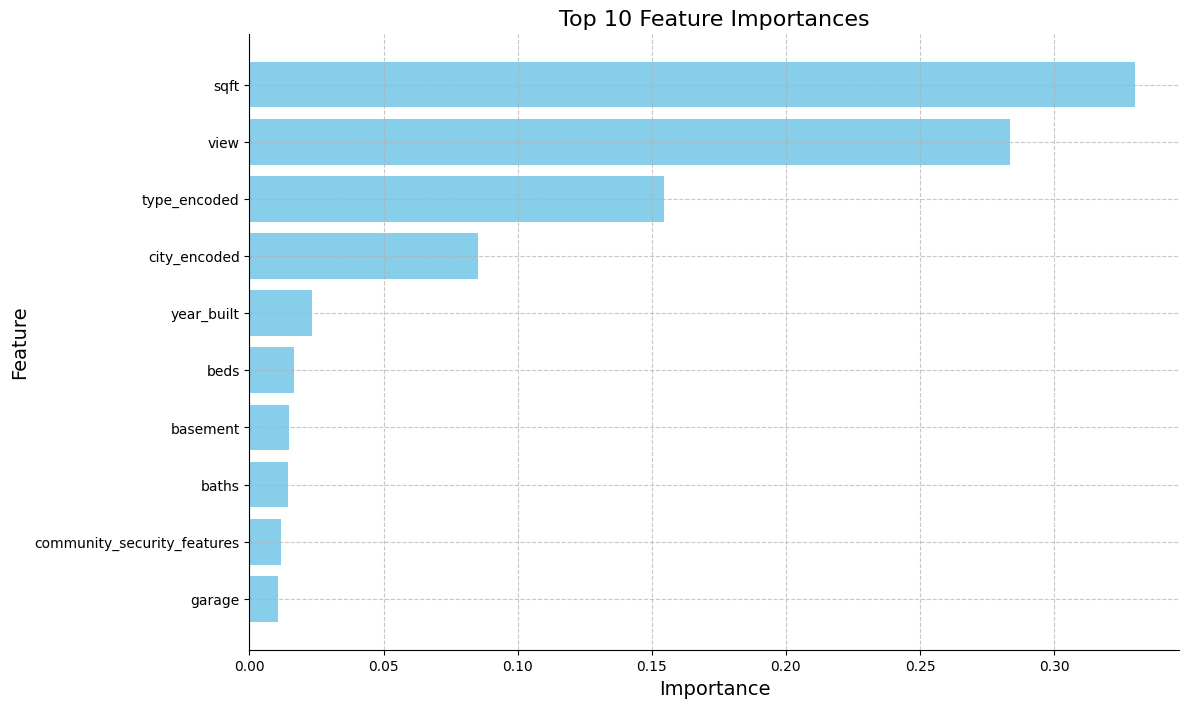

In [127]:

# Get feature importances from the model

feature_importances = loaded_model.feature_importances_
features = X.columns


# Create a DataFrame for feature importances

importance_df = pd.DataFrame({'Feature': features,
                              'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'],
         importance_df['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Feature Importances', fontsize=16)
plt.gca().invert_yaxis()

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Removing spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

***Note: The above chart shows `sqft` as the most important feature. This is in alignment with the heat map generated from part 1 EDA.*** 


![heatmap](../images/correlation_heatmap_new.png)

In [128]:
model_filename = '../models/refined_final_decision_tree_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to ../models/refined_final_decision_tree_model.pkl


#### Prediction Function

In [129]:
# An idea for a function that we could've used above to make things a lot easier. This could also be used in a sample pipeline
def load_model(model_path):
    """Load the trained model from the file."""
    return joblib.load(model_path)


def predict(data, model):
    """Predict the target variable using the trained model."""
    predictions = model.predict(data)
    return predictions


### **Pipeline**

This process encapsulates the entire workflow, including data preprocessing, model training, and prediction into a single pipeline. The pipeline is then saved to a file, which can be loaded in the future for making predictions on new data

In [130]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

# Define numerical and categorical features
numerical_features = ['year_built', 'sqft', 'baths', 'stories', 'beds', 'garage',
                      'garage_1_or_more', 'garage_2_or_more', 'hardwood_floors',
                      'laundry_room', 'recreation_facilities', 'shopping', 'single_story', 'two_or_more_stories']
categorical_features = ['type', 'city']

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [131]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [132]:
# Split the data into training and test sets
X = df_final.drop(columns=['price'])
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year_built', 'sqft',
                                                   'baths', 'stories', 'beds',
                                                   'garage', 'garage_1_or_more',
                                                   'garage_2_or_more',
                                                   'hardwood_floors',
                                                   'laundry_room',
                                                   'recreation_facilities',
                                                   'shopping', 'single_story',
                                                   'two_or_more_stories']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type', 'city'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [133]:
#Save the pipeline
pipeline_filename = '../models/pipeline/final_pipeline.pkl'
joblib.dump(pipeline, pipeline_filename)
print(f"Pipeline saved to {pipeline_filename}")

Pipeline saved to ../models/pipeline/final_pipeline.pkl


### Test model and pipeline

In [134]:
df_final_part3

,year_built,sqft,baths,stories,beds,garage,is_foreclosure,price,basement,central_air,...,hardwood_floors,laundry_room,recreation_facilities,shopping,single_story,two_or_more_stories,view,washer_dryer,city_encoded,type_encoded
0,1990,1500,2.0,1.0,3.0,2.0,False,200000,0,1,...,0,0,1,0,1,0,1,0,28,4
1,2000,2000,3.0,2.0,3.0,2.0,False,200000,0,1,...,0,0,0,0,0,1,0,0,28,4
2,2000,2000,2.0,2.0,3.0,2.0,False,200000,0,1,...,1,0,0,0,0,1,1,0,28,4
3,1980,500,2.0,2.0,2.0,1.0,False,0,0,1,...,0,0,1,1,0,1,1,0,28,1
4,2000,3000,3.0,2.0,4.0,2.0,False,200000,0,0,...,0,0,1,1,0,1,1,0,28,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,1980,1000,3.0,2.0,3.0,2.0,False,200000,1,1,...,0,0,0,0,0,1,0,0,24,4
4834,1980,4500,4.0,4.0,4.0,2.0,False,600000,1,1,...,1,0,0,0,0,1,0,0,24,4
4835,1990,2000,3.0,2.0,3.0,2.0,False,400000,1,1,...,0,0,0,0,0,1,0,1,24,4
4836,1890,2500,3.0,3.0,3.0,0.0,False,200000,1,1,...,0,0,0,0,0,1,1,0,24,5


In [135]:

# Load the saved pipeline
pipeline_filename = '../models/pipeline/final_pipeline.pkl'
loaded_pipeline = joblib.load(pipeline_filename)

In [136]:
y_test

3197    400000
2526    200000
4099    400000
1926    600000
1536         0
         ...  
4324    400000
3673         0
3830    600000
1135    200000
180          0
Name: price, Length: 968, dtype: int64

In [137]:
# Take a sample from X_test
X_test_sample = X_test[0:5]

# Make predictions using the loaded pipeline on sample
predicted_prices_sample = loaded_pipeline.predict(X_test_sample)

# Display the sample dataframe with predicted prices
print(predicted_prices_sample)

[400000. 200000. 400000. 600000.      0.]


In [138]:
#compare above output with output below. If it's the same then the model worked
print(y_test[0:5])

3197    400000
2526    200000
4099    400000
1926    600000
1536         0
Name: price, dtype: int64
